## Capstone --- Build Abstractive summarization model.


#### Shuaichen Wu

## Introduction

The purpose of this notebook is to Build abstractive summarization model for podcast transcripts.

Diffferent from extractive summarization model, abstracitve summarization is to generate short summary that captures the main ideas of a text.
The generated summaries potentially contain new phrases and sentences that may not appear in original text.

## Import library

In [3]:
#for built neuro network
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import rouge

from attention import AttentionLayer

## model building

### Get the half of Dataset

In [8]:
# first I need read the dataset I double cleaned
train = joblib.load('second_clean_train.pkl')

In [9]:
#check the shape
train.shape

(32354, 2)

Consider the computation momery and run time neuro network need, I decide to decrease the train dataset to half, choose from the 25% to 75% in length of summary.

In [10]:
len_summary = train['summary'].apply(lambda x:len(x.split()))

In [11]:
len_summary.describe()

count    32354.000000
mean        82.199944
std         65.661362
min         21.000000
25%         42.000000
50%         63.000000
75%         99.000000
max        740.000000
Name: summary, dtype: float64

In [12]:
start_ = np.quantile(len_summary,0.25)
_end = np.quantile(len_summary,0.75)

In [13]:
train_half = np.where((len_summary>start_) & (len_summary<_end))

In [14]:
# get the half size of data
train_half = train.loc[train_half]

In [5]:
train_half=pd.read_csv('train_half.csv')

In [6]:
train_half.shape

(15729, 3)

Check the length of transcripts of the half dataset.

In [7]:
len_transcript_half = train_half['transcript'].apply(lambda x:len(x.split()))

In [8]:
len_transcript_half.describe()

count    15729.000000
mean      7177.436455
std       4023.316547
min         27.000000
25%       3967.000000
50%       6734.000000
75%      10030.000000
max      22216.000000
Name: transcript, dtype: float64

The central transcripts still have 7177±4023 words, which is compatibel with full size summaries.

In [9]:
len_summary_half = train_half['summary'].apply(lambda x:len(x.split()))

In [10]:
len_summary_half.describe()

count    15729.000000
mean        65.613707
std         15.519773
min         43.000000
25%         52.000000
50%         63.000000
75%         78.000000
max         98.000000
Name: summary, dtype: float64

For summries, the central length become 65 ± 15,
which is better for build a summarization model.

Now put transcript and summary into X and y, split it into train and test dataset.

Then, split the train into train and validation dataset.

In [11]:
X=train_half['transcript']
y=train_half['summary']

In [12]:
np.random.seed(100)

In [13]:
#split into train-validation and test dataset
X_, X_test, y_, y_test = train_test_split(X,y,test_size=0.2,random_state=100)

In [14]:
#split into train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_,y_,test_size=0.1,random_state=100)

In [15]:
X_train.shape

(11324,)

In [16]:
y_train.shape

(11324,)

### Get the transcript tokens and encoder size

For I will build RNN sequence to sequence model.
The Architecture will be like this:

<img src="http://drive.google.com/uc?export=view&id=14iYh3JU7OiMz2--fPFXrEiagw1juHruI" height=400 width=600></img>


The architecture seperate the input encoding and output encoding complettely.

In this encoder decoder model, the encoder module that processes the input sequence to produce a single vector as a representation for the input.

This vector is fed into the decodre module, which generates the output sequence in an auto-regressive fashion.

And the first step output of the decoder is fed as the input of the second-step and so on.

In the RNN model I will build, a transcript will be the input sequence which will be encoder processed as a single vector later.


Encoder model can't read raw text.

First I need tokenizer my whole transcript corpus.

Second I need use represent my whole transcript corpus with word tokens index.

Third I need pad my document sequence, encoder model deal with the same size of document sequence.


<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/61.jpg" height=400 width=600></img>

The diagram[1] above describe how encoder work. At each step, One word is fed into the encoder. At the end, the hidden state h, and the cell state c will be used to initialize the decoder.


The shape of input for recurrent network will be n*q*d:

n: the number of obseravation
the number of the sequence

q: the sequence length

d: the number of feature for each element belong to the sequence.

In my RNN model, the number of observation will be the train size
the sequence length will be the max length of my transcripts
the number of feature for each element will be the embeding dimension.



Now I need explore train dataset.

Check the rare words for transcripts in train dataset. How much the rare words makes up the whole corpus.

In [17]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(X_train)

In [18]:
thresh=6 #threshold to define a rare word
rare=0 #how many rare words in the corpus
unique=0 # how many unique words in the corpus
rare_freq=0 # how many times the rare words shows up
freq = 0 # how long the whole corpus is
for key,value in x_tokenizer.word_counts.items():
    unique=unique+1
    freq=freq+value
    if(value<thresh):
        rare=rare+1
        rare_freq=rare_freq+value
print(f'Percentage of rare words in summary vocabulary:{round(rare/unique*100,2)}%')
print(f'Total Coverage of rare words for summary:{round(rare_freq/freq*100,2)}%')

Percentage of rare words in summary vocabulary:58.79%
Total Coverage of rare words for summary:0.22%


I define rare word as tokens that show up less than 6 times, in whole corpus.

These kind rare words makes up 58% all tokens, but only shows up contribute to 0.23% of corpus.


I decide to exclude all the rare words in the tokenizer by set num_words=(unique-rare),

When I use function text_to_sequence, only indexes of top num_words frequent words will be returned.

In [19]:
#now I need build new tokenizer
x_tokenizer = Tokenizer(num_words=unique-rare)
x_tokenizer.fit_on_texts(X_train)

In [20]:
#transform word in sentences into index of word token
X_train_toseq = x_tokenizer.texts_to_sequences(X_train)
#create sequence for validation set
X_val_toseq = x_tokenizer.texts_to_sequences(X_val)

In [21]:
#consider decrease the parameter to train, set max_x_len as quantile 75%
np.quantile(len_transcript_half,0.75)

10030.0

In [22]:
max_x_len = 10030 #75% of the transcripts are lower than 10030 words

In [23]:
#pading zero up tp maximum length of sequence
X_train_pad = pad_sequences(X_train_toseq, maxlen = max_x_len, padding = 'post')
#pading zero up tp maximum length of sequence
X_val_pad = pad_sequences(X_val_toseq, maxlen = max_x_len, padding = 'post')

In [203]:
joblib.dump(X_train_pad,'x_train_pad.pkl')

['x_train_pad.pkl']

In [204]:
joblib.dump(X_val_pad,'x_val_pad.pkl')

['x_val_pad.pkl']

Now I can do the same thing to summary.

First I need add start and end to the summary.

The Diagram describe the decoder architecture, which reads the entire target sequence word by word and predicts 
the same sequence offset by one timestep.

The encoder is trained to predict the next word in the sequence given the previous word.


<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/71.jpg" height=400 width=600></img>


Start and end are the special tokens which are added to the target sequence before feeding into decoder.


In [24]:
#Add start and end tokens to the y_train
y_train = y_train.apply(lambda x: 'sostok '+ x + ' eostok')
y_val = y_val.apply(lambda x: 'sostok '+ x + ' eostok')

In [25]:
#check the head
y_train.head()

2065    sostok now, i love chinese food. i mean, who d...
5936    sostok time blocking has practically become a ...
1406    sostok tonight i am joined by duracell battery...
4431    sostok please bear with us for the choppy edit...
4764    sostok before cutting ties release their debut...
Name: summary, dtype: object

In [26]:
y_val.head()

852      sostok in this episode,​ i am joined by rich r...
4701     sostok and we are back! happy new year to you ...
11761    sostok fresh off the packers' win over the vik...
11475    sostok well, here it is! 2012 and all that hap...
15712    sostok lean in as jasmine, business owner, mot...
Name: summary, dtype: object

In [27]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_train)

In [28]:
thresh=6 #threshold to define a rare word
rare=0 #how many rare words in the corpus
unique=0 # how many unique words in the corpus
rare_freq=0 # how many times the rare words shows up
freq = 0 # how long the whole corpus is
for key,value in y_tokenizer.word_counts.items():
    unique=unique+1
    freq=freq+value
    if(value<thresh):
        rare=rare+1
        rare_freq=rare_freq+value
print(f'Percentage of rare words in summary vocabulary:{round(rare/unique*100,2)}%')
print(f'Total Coverage of rare words for summary:{round(rare_freq/freq*100,2)}%')

Percentage of rare words in summary vocabulary:81.43%
Total Coverage of rare words for summary:7.73%


For summary, the rare words take up to 81% of all tokens, but only contribute to 7% of corpus.

In [29]:
#Based on the situation, I build a new tokenizer
y_tokenizer = Tokenizer(num_words=unique-rare)
y_tokenizer.fit_on_texts(y_train)

In [43]:
y_tokenizer.word_index['sostok']

7

In [44]:
y_tokenizer.word_index['eostok']

8

In [45]:
#transform word in sentences into index of word token
y_train_toseq = y_tokenizer.texts_to_sequences(y_train)
#create sequence for validation set
y_val_toseq = y_tokenizer.texts_to_sequences(y_val)

In [46]:
max_y_len = max(len_summary_half)

In [47]:
max_y_len

98

In [48]:
#pading zero up tp maximum length of sequence
y_train_pad = pad_sequences(y_train_toseq, maxlen = max_y_len, padding = 'post')
#pading zero up tp maximum length of sequence
y_val_pad = pad_sequences(y_val_toseq, maxlen = max_y_len, padding = 'post')

## First One LSTM layer for encoder and decoder

In [49]:
x_voc = x_tokenizer.num_words+1
y_voc = y_tokenizer.num_words+1
print(f'Transcripts vocabulary is {x_voc}, Summaries vocabulary is {y_voc}.')

Transcripts vocabulary is 64751, Summaries vocabulary is 8395.


In [50]:
from keras import backend as K
K.clear_session()

For the first model,  I set dropout = 0.4, epoches = 10, and batch_size = 128 in this time.

In [51]:

dropout = 0.2
epochs = 50
batch_size = 128
embedding_dim = 100
latent_dim = 100

In [52]:

#encoder: x input initiate
x_in = Input(shape=(max_x_len,))
#embedding
layer_x_emb = Embedding(x_voc,embedding_dim,trainable=True)
x_emb = layer_x_emb(x_in)
##lstm
layer_x_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout)
x_out, state_h, state_c = layer_x_lstm(x_emb)

In [53]:
#decoder
#y input initiate
y_in = Input(shape=(None,))
#embedding layer
layer_y_emb = Embedding(y_voc, embedding_dim, trainable=True)
y_emb = layer_y_emb(y_in)
#lstm
layer_y_lstm = LSTM(latent_dim, return_sequences =True, return_state= True, dropout = dropout)
y_out, y_h2,  y_c2 = layer_y_lstm(y_emb,initial_state=[state_h,state_c])
#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
y_out = decoder_dense(y_out)

In [54]:
# Compile model
model = Model([x_in, y_in], y_out)
# Display its summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10030)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10030, 100)   6475100     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    839500      input_2[0][0]                    
_______________________________________________________________________________________

In [55]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') #classifier
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) #epoch early stopping

In [56]:
history=model.fit([X_train_pad,y_train_pad[:,:-1]],\
                  y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,\
                  epochs=epochs,\
                  callbacks=[es],\
                  batch_size=batch_size, \
                  validation_data=([X_val_pad,y_val_pad[:,:-1]], \
                                   y_val_pad.reshape(y_val_pad.shape[0],y_val_pad.shape[1], 1)[:,1:]))

Epoch 1/50
89/89 [==============================] - 70s 790ms/step - loss: 5.2964 - val_loss: 4.2768
Epoch 2/50
89/89 [==============================] - 70s 781ms/step - loss: 4.2443 - val_loss: 4.0718
Epoch 3/50
89/89 [==============================] - 69s 781ms/step - loss: 4.1228 - val_loss: 3.9855
Epoch 4/50
89/89 [==============================] - 70s 784ms/step - loss: 4.0378 - val_loss: 3.9120
Epoch 5/50
89/89 [==============================] - 69s 780ms/step - loss: 3.9587 - val_loss: 3.8350
Epoch 6/50
89/89 [==============================] - 69s 778ms/step - loss: 3.8745 - val_loss: 3.7615
Epoch 7/50
89/89 [==============================] - 70s 783ms/step - loss: 3.7983 - val_loss: 3.6958
Epoch 8/50
89/89 [==============================] - 70s 781ms/step - loss: 3.7351 - val_loss: 3.6477
Epoch 9/50
89/89 [==============================] - 69s 775ms/step - loss: 3.6835 - val_loss: 3.6083
Epoch 10/50
89/89 [==============================] - 70s 789ms/step - loss: 3.6393 - val_lo

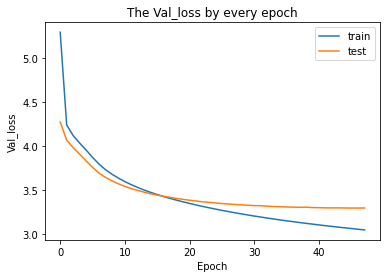

In [57]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.title('The Val_loss by every epoch')
plt.legend() 
plt.show()

## Build the First Inference model

In [58]:
x_index_word = x_tokenizer.index_word
y_index_word = y_tokenizer.index_word
y_word_index = y_tokenizer.word_index

In [59]:
#encoder inference
encoder_model = Model(inputs = x_in, outputs = [x_out, state_h, state_c])
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10030)]           0         
_________________________________________________________________
embedding (Embedding)        (None, 10030, 100)        6475100   
_________________________________________________________________
lstm (LSTM)                  [(None, 10030, 100), (Non 80400     
Total params: 6,555,500
Trainable params: 6,555,500
Non-trainable params: 0
_________________________________________________________________


In [61]:
encoder_model.save('en1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: en1/assets


In [62]:
# decoder inference

encoder_out = Input(shape=(max_x_len,latent_dim))                 
decoder_state_h = Input(shape=(latent_dim,))
decoder_state_c = Input(shape=(latent_dim,))
                               
# decoder embedding                
dec_emb = layer_y_emb(y_in)
                
#lstm to predict the next word                
dec_out2, dec_state_h2, dec_state_c2 = layer_y_lstm(dec_emb, initial_state = [decoder_state_h, decoder_state_c])
                
#use softmax to generate probability over vocabular
probas = decoder_dense(dec_out2)
                
#compile
decoder_model = Model(inputs=[y_in, encoder_out, decoder_state_h, decoder_state_c], outputs=[probas, dec_state_h2, dec_state_c2])
decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    839500      input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100)]        0                                            
_______________________________________________________________________________________

In [63]:
decoder_model.save('de1')

INFO:tensorflow:Assets written to: de1/assets


In [64]:
# # predict for one test pad
def decode_padding(x):
    x=x.reshape(1,max_x_len)
    #encoder X
    e_out, e_state_h, e_state_c = encoder_model.predict(x)
    #The word feed in 
    target_seq = np.array([y_word_index['sostok']])
    predicted_text=""
    stop = False

    while not stop:
        #predict the dictionary probability
        tokens, new_state_h, new_state_c = decoder_model.predict([target_seq, e_out, e_state_h, e_state_c])
        #get predict word
        voc_idx = np.argmax(tokens[0,-1,:])
        pred_word = y_index_word[voc_idx]

        #check the stop
        if (pred_word != 'eostok') and (len(predicted_text.split()) < max_y_len):
            predicted_text = predicted_text + " " + pred_word
        else:
            stop=True
        #next
        target_seq = np.array([voc_idx])
        e_state_h, e_state_c = new_state_h, new_state_c
    return predicted_text

In [70]:
decode_padding(X_val_pad[900])

' in this episode we talk about the importance of the and the most important things we have learned from the world of the world and how to make it and how to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we have to do we'

In [ ]:
y_test[900]

From the summary generated, I know basically the encoder and decoder layer didn't learn much through the training phase, All the predicted summary are basic the same and basically not related to original summary.

Based on the situation, I go through some paper, I found out LSTMs work well if the problem has one output for every input, like time series foresting or text translation.

LSTMs can be chanllenging to use, when the input sequences are very long and the outputs are much shorter, which exactly is in our case.

I decide manually truncate it to half the size.

In [ ]:
# x_voc = 
# y_voc =
max_x_len = 5000
max_y_len = 100

### Some hyperparameter tuning And Normalization layers.

Try to run 50 epochs, Decrease batch_size to 64, and change the dropout as 0.4 and also I add recurrent_regularizer=regularizers.l2(0.01).

And I add Four batch normalization layers.

In [74]:
dropout = 0.4
epochs = 50
batch_size = 128
embedding_dim = 100 #decrease embedding dimension will decrease running time
latent_dim = 100

In [75]:
from keras import backend as K
from keras import regularizers
import tensorflow as tf
K.clear_session()

In [76]:

#And batch normalization 
bn1 = BatchNormalization()
bn2 = BatchNormalization()

#encoder
x_in = Input(shape=(max_x_len,))

#embedding
layer_x_emb = Embedding(x_voc,embedding_dim,trainable=True)
x_emb = layer_x_emb(x_in)
x_emb = bn1(x_emb)

##lstm
layer_x_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_regularizer=regularizers.l2(0.01))
x_out, state_h, state_c = layer_x_lstm(x_emb)
x_out = bn2(x_out)

#decoder
#And batch normalization 
bn3 = BatchNormalization()
bn4 = BatchNormalization()

#
y_in = Input(shape=(None,))

#embedding layer
layer_y_emb = Embedding(y_voc, embedding_dim, trainable=True)

y_emb = layer_y_emb(y_in)
y_emb = bn3(y_emb)

#lstm
layer_y_lstm = LSTM(latent_dim, return_sequences =True, return_state= True, dropout = dropout, recurrent_regularizer=regularizers.l2(0.01))

y_out, y_h,  y_c = layer_y_lstm(y_emb,initial_state=[state_h,state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))

y_out = bn4(y_out)
y_out = decoder_dense(y_out)

In [77]:
# Compile model
model = Model([x_in, y_in], y_out)
# Display its summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    6475100     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    839500      input_2[0][0]                    
_______________________________________________________________________________________

In [78]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
checkpoint_filepath='./checkpoint1/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [79]:
history=model.fit([X_train_pad,y_train_pad[:,:-1]],\
                  y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,\
                  epochs=epochs,\
                  callbacks=[model_checkpoint_callback],\
                  batch_size=batch_size , \
                  validation_data=([X_val_pad,y_val_pad[:,:-1]], \
                                   y_val_pad.reshape(y_val_pad.shape[0],y_val_pad.shape[1], 1)[:,1:]))

Epoch 1/50
89/89 [==============================] - 72s 811ms/step - loss: 5.8680 - val_loss: 8.2115
Epoch 2/50
89/89 [==============================] - 71s 801ms/step - loss: 3.9360 - val_loss: 7.6508
Epoch 3/50
89/89 [==============================] - 72s 804ms/step - loss: 3.6727 - val_loss: 5.6649
Epoch 4/50
89/89 [==============================] - 72s 807ms/step - loss: 3.5534 - val_loss: 4.0789
Epoch 5/50
89/89 [==============================] - 72s 804ms/step - loss: 3.4738 - val_loss: 3.6650
Epoch 6/50
89/89 [==============================] - 71s 801ms/step - loss: 3.4142 - val_loss: 3.4579
Epoch 7/50
89/89 [==============================] - 72s 804ms/step - loss: 3.3666 - val_loss: 3.3748
Epoch 8/50
89/89 [==============================] - 71s 803ms/step - loss: 3.3248 - val_loss: 3.3368
Epoch 9/50
89/89 [==============================] - 71s 801ms/step - loss: 3.2916 - val_loss: 3.3308
Epoch 10/50
89/89 [==============================] - 72s 807ms/step - loss: 3.2606 - val_lo

KeyboardInterrupt: 

I stopped when there are no more improvement.

Some interesting oberservation during hyperparametr tuning.

When I set batch size small, the ETA also get much higher number.

The embedding layer is the make ups marjority of parameters.

### Second Inference for Model with Batch-normalization layer

In [91]:
#encoder inference
encoder_model = Model(inputs = x_in, outputs = [x_out, state_h, state_c])
encoder_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 5000, 100)         6475100   
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 100)         400       
_________________________________________________________________
lstm (LSTM)                  [(None, 5000, 100), (None 80400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000, 100)         400       
Total params: 6,556,300
Trainable params: 6,555,900
Non-trainable params: 400
_________________________________________________________________


In [93]:
encoder_model.save('en2')

INFO:tensorflow:Assets written to: en2/assets


In [92]:
# decoder inference
#initiate the input for decoder model
encoder_out = Input(shape=(max_x_len,latent_dim))                    
decoder_state_h = Input(shape=(latent_dim,))
decoder_state_c = Input(shape=(latent_dim,))
                                
# decoder embedding                
dec_emb = layer_y_emb(y_in)
dec_emb = bn3(dec_emb)                
#lstm to predict the next word                
dec_out2, dec_state_h2, dec_state_c2 = layer_y_lstm(dec_emb, initial_state = [decoder_state_h, decoder_state_c])
dec_out2 = bn4(dec_out2)                
#use softmax to generate probability over vocabular
probas = decoder_dense(dec_out2)                
#compile
decoder_model = Model(inputs=[y_in, encoder_out, decoder_state_h, decoder_state_c], outputs=[probas, dec_state_h2, dec_state_c2])

decoder_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    839500      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, 100)    400         embedding_1[2][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 100)]        0                                            
_______________________________________________________________________________________

In [94]:
decoder_model.save('de2')

INFO:tensorflow:Assets written to: de2/assets


In [86]:
decode_padding(X_train_pad[890][:5000])

' the guys are back in the first episode of the season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming season of the week we talk about the upcoming'

In [87]:
decode_padding(X_train_pad[1200][:5000])

' is a good friend and a good friend and a friend of mine and we talk about the importance of being a good friend and how to get a little bit of the best and how to make it a good time to get a little bit of the best and bad things that is not only the best thing you can find out what you think'

In [89]:
decode_padding(X_train_pad[2499][:5000])

' on this episode of the guys discuss the recent trip to the nfl playoffs and the guys discuss the recent trip to the nfl playoffs and the guys discuss the upcoming season of the season and the guys discuss the upcoming season of the season and the guys discuss the upcoming season of the season'

The result proved my assumption, that the encoder and decoder can't handle long sequence, After I cut sequence into half, the quality of summaries spike up.

Now the question become How to shorten the sequence. 

Based the extractive models I built, Baseline model and Text rank, TFIDF, Count Vectorizer model,
I found that simply Baseline model and Text rank out performed others in F1 SCores.

I wanna try those two:

1, the first 5000 words

2, text rank, word_count = 5000

I decide to try the baseline model first, which is to pick first K words.

## Truncate Text Size

Now I need redo the tokenizer and everything

In [190]:
K=1000
First_500 = train_half['transcript'].apply(lambda x : ' '.join(x.split()[:K]))

In [191]:
X=First_500
y=train_half['summary']

In [192]:
np.random.seed(100)

In [193]:
#split into train-validation and test dataset
X_, X_test, y_, y_test = train_test_split(X,y,test_size=0.2,random_state=100)

In [194]:
#split into train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_,y_,test_size=0.1,random_state=100)

In [195]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(X_train)

In [196]:
#transform word in sentences into index of word token
X_train_toseq = x_tokenizer.texts_to_sequences(X_train)
#create sequence for validation set
X_val_toseq = x_tokenizer.texts_to_sequences(X_val)

In [197]:
max_x_len=5000

In [198]:
#pading zero up tp maximum length of sequence
X_train_pad = pad_sequences(X_train_toseq, maxlen = max_x_len, padding = 'post')
#pading zero up tp maximum length of sequence
X_val_pad = pad_sequences(X_val_toseq, maxlen = max_x_len, padding = 'post')

In [199]:
#Add start and end tokens to the y_train
y_train = y_train.apply(lambda x: 'sostok '+ x + ' eostok')
y_val = y_val.apply(lambda x: 'sostok '+ x + ' eostok')

In [200]:
#check the head
y_train.head()

2065    sostok now, i love chinese food. i mean, who d...
5936    sostok time blocking has practically become a ...
1406    sostok tonight i am joined by duracell battery...
4431    sostok please bear with us for the choppy edit...
4764    sostok before cutting ties release their debut...
Name: summary, dtype: object

In [201]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_train)

In [202]:
max_y_len = max(len_summary_half) 

In [203]:
#pading zero up tp maximum length of sequence
y_train_pad = pad_sequences(y_train_toseq, maxlen = max_y_len, padding = 'post')
#pading zero up tp maximum length of sequence
y_val_pad = pad_sequences(y_val_toseq, maxlen = max_y_len, padding = 'post')

In [205]:
x_voc = len(x_tokenizer.index_word)+1
y_voc = len(y_tokenizer.index_word)+1
print(f'Transcripts vocabulary is {x_voc}, Summaries vocabulary is {y_voc}.')


Transcripts vocabulary is 80308, Summaries vocabulary is 45195.


The transcripts vocabulary decrease so much.

In [206]:
from keras import backend as K
from keras import regularizers
import tensorflow as tf
K.clear_session()

In [207]:
dropout = 0.4
r_dropout = 0
epochs = 50
batch_size = 128
embedding_dim = 100 #decrease embedding dimension will decrease running time
latent_dim = 100

In [208]:

#And batch normalization 
bn1 = BatchNormalization()
bn2 = BatchNormalization()
bn3 = BatchNormalization()
bn4 = BatchNormalization()


#encoder
x_in = Input(shape=(max_x_len,))

#embedding
layer_x_emb = Embedding(x_voc,embedding_dim,trainable=True)
x_emb = layer_x_emb(x_in)
x_emb = bn1(x_emb)

##lstm
layer_x_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_regularizer=regularizers.l2(0.01))
x_out3, x_state_h3, x_state_c3 = layer_x_lstm(x_emb)

##lstm 2
layer_x_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_regularizer=regularizers.l2(0.01))
x_out2, x_state_h2, x_state_c2 = layer_x_lstm2(x_out3)

##lstm 3
layer_x_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout, recurrent_regularizer=regularizers.l2(0.01))
x_out, x_state_h, x_state_c = layer_x_lstm3(x_out2)
x_out = bn3(x_out)

#decoder
y_in = Input(shape=(None,))

#embedding layer
layer_y_emb = Embedding(y_voc, embedding_dim, trainable=True)
y_emb = layer_y_emb(y_in)
y_emb = bn3(y_emb)

#lstm
layer_y_lstm = LSTM(latent_dim, return_sequences =True, return_state= True, dropout = dropout, recurrent_dropout=r_dropout,recurrent_regularizer=regularizers.l2(0.01))
y_out, y_h,  y_c = layer_y_lstm(y_emb,initial_state=[x_state_h,x_state_c])
y_out = bn4(y_out)
#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
y_out = decoder_dense(y_out)

In [209]:
# Compile model
model = Model([x_in, y_in], y_out)
# Display its summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    8030800     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5000, 100)    400         embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [210]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) #epoch early stopping

In [211]:
history=model.fit([X_train_pad,y_train_pad[:,:-1]],\
                  y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,\
                  epochs=epochs,\
                  callbacks=[es],\
                  batch_size=batch_size , \
                  validation_data=([X_val_pad,y_val_pad[:,:-1]], \
                                   y_val_pad.reshape(y_val_pad.shape[0],y_val_pad.shape[1], 1)[:,1:]))

Epoch 1/50
89/89 [==============================] - 99s 1s/step - loss: 7.4253 - val_loss: 9.3810
Epoch 2/50
89/89 [==============================] - 98s 1s/step - loss: 4.1403 - val_loss: 7.8634
Epoch 3/50
89/89 [==============================] - 98s 1s/step - loss: 3.8027 - val_loss: 6.0057
Epoch 4/50
89/89 [==============================] - 98s 1s/step - loss: 3.6452 - val_loss: 4.2608
Epoch 5/50
89/89 [==============================] - 98s 1s/step - loss: 3.5458 - val_loss: 3.7304
Epoch 6/50
89/89 [==============================] - 98s 1s/step - loss: 3.4754 - val_loss: 3.5024
Epoch 7/50
89/89 [==============================] - 98s 1s/step - loss: 3.4208 - val_loss: 3.4098
Epoch 8/50
89/89 [==============================] - 98s 1s/step - loss: 3.3745 - val_loss: 3.3675
Epoch 9/50
89/89 [==============================] - 98s 1s/step - loss: 3.3352 - val_loss: 3.3402
Epoch 10/50
89/89 [==============================] - 98s 1s/step - loss: 3.3034 - val_loss: 3.3180
Epoch 11/50
89/89 [

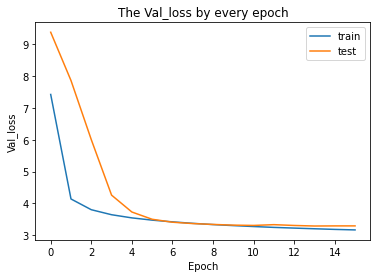

In [212]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.title('The Val_loss by every epoch')
plt.legend() 
plt.show()

In [179]:
#encoder inference
encoder_model = Model(inputs = x_in, outputs = [x_out, x_state_h, x_state_c])
encoder_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 5000, 100)         5357200   
_________________________________________________________________
batch_normalization_4 (Batch (None, 5000, 100)         400       
_________________________________________________________________
lstm_4 (LSTM)                [(None, 5000, 100), (None 80400     
_________________________________________________________________
lstm_5 (LSTM)                [(None, 5000, 100), (None 80400     
_________________________________________________________________
lstm_6 (LSTM)                [(None, 5000, 100), (None 80400     
_________________________________________________________________
batch_normalization_6 (Batch multiple                 

In [213]:
# decoder inference
#initiate the input for decoder model
encoder_out = Input(shape=(max_x_len,latent_dim))                    
decoder_state_h = Input(shape=(latent_dim,))
decoder_state_c = Input(shape=(latent_dim,))
                                
# decoder embedding                
dec_emb = layer_y_emb(y_in)
dec_emb = bn3(dec_emb)                
#lstm to predict the next word                
dec_out2, dec_state_h2, dec_state_c2 = layer_y_lstm(dec_emb, initial_state = [decoder_state_h, decoder_state_c])
dec_out2 = bn4(dec_out2)                
#use softmax to generate probability over vocabular
probas = decoder_dense(dec_out2)                
#compile
decoder_model = Model(inputs=[y_in, encoder_out, decoder_state_h, decoder_state_c], outputs=[probas, dec_state_h2, dec_state_c2])

decoder_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    4519500     input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor multiple             400         embedding_1[1][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
_______________________________________________________________________________________

In [215]:
decode_padding(X_val_pad[789])

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[0,444] = 75045 is not in [0, 53572)
	 [[node functional_5/embedding_2/embedding_lookup (defined at <ipython-input-64-f370cd0f122a>:5) ]]
  (1) Invalid argument:  indices[0,444] = 75045 is not in [0, 53572)
	 [[node functional_5/embedding_2/embedding_lookup (defined at <ipython-input-64-f370cd0f122a>:5) ]]
	 [[functional_5/embedding_2/embedding_lookup/_6]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_206668]

Errors may have originated from an input operation.
Input Source operations connected to node functional_5/embedding_2/embedding_lookup:
 functional_5/embedding_2/embedding_lookup/205306 (defined at /usr/lib/python3.8/contextlib.py:113)

Input Source operations connected to node functional_5/embedding_2/embedding_lookup:
 functional_5/embedding_2/embedding_lookup/205306 (defined at /usr/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function -> predict_function


## Conclusion

IN this notebook, I build three Neural network models, two without attention layers, one with attention layers.
I did some hyperparameter tuning for all the neural network models.

dropout would help with overfitting.
Batch normalization could acts as regularization and also could help with overfitting.

I also add layer regularizaiton for LSTM layer ---l2,regularization

reference

[1]Seq2Seq: Abstractive Summarization Using LSTM and Attention Mechanism. Madhav Mishra. Aug 14,2020.
https://medium.com/analytics-vidhya/seq2seq-abstractive-summarization-using-lstm-and-attention-mechanism-code-da2e9c439711